In [84]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [43]:
# perform camera calibration
images = glob.glob('camera_cal/calibration*.jpg')
object_pts = []
image_pts = []
nx = 9
ny = 6
objpts = np.zeros((ny*nx,3),np.float32)
objpts[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
for image in images:
    gray = cv2.cvtColor(plt.imread(image),cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret == True:
        image_pts.append(corners)
        object_pts.append(objpts)
any = plt.imread(images[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_pts, image_pts, (nx,ny), None, None)

In [44]:
# undistort image
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

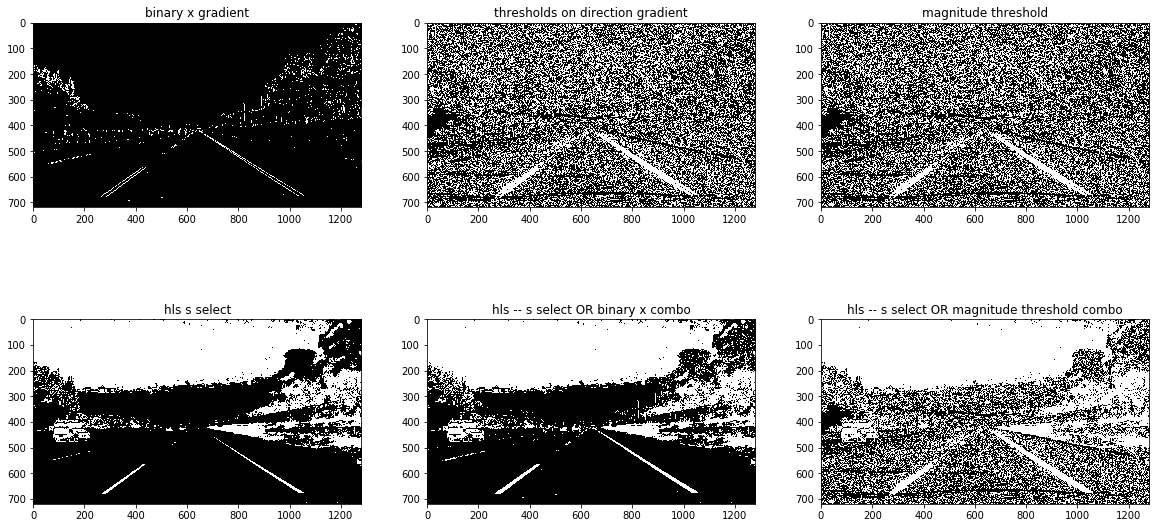

In [151]:
# Use color transforms, gradients, etc., to create a thresholded binary image. 
def sobel(img, direction, ksize): # grayscale image
    if direction == 'x':
        sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize)
        return sobel_x
    elif direction == 'y':
        sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize)
        return sobel_y

def sobel_binary(img,direction,ksize,min_thres,max_thres):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel_x = sobel(gray,direction,ksize)
    sobel_x_abs = np.absolute(sobel_x)
    sobel_x_scale = 255*(sobel_x_abs/np.max(sobel_x_abs))
    binary_x = np.zeros_like(sobel_x_scale)
    binary_x[(sobel_x_scale >= min_thres) & (sobel_x_scale <= max_thres)]=1
    return binary_x

def dir_threshold(img,ksize=15,thres=(0,np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=ksize)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=ksize)
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)
    arctan = np.arctan2(sobel_y_abs,sobel_x_abs)
    binary_arctan = np.zeros_like(arctan)
    binary_arctan[(arctan >= thres[0]) & (arctan <= thres[1])]=1
    return binary_arctan

def mag_thresh(img,ksize=3,thresh=(0,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=ksize)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=ksize)
    sobel = np.zeros_like(sobel_x)
    for i in range(len(sobel)):
        sobel[i] = np.sqrt(np.power(sobel_x[i],2)+np.power(sobel_y[i],2))
    sobel_scale = np.int8(255*sobel/np.max(sobel))
    binary = np.zeros_like(sobel_scale)
    binary[(sobel_scale >= thresh[0]) & (sobel_scale <= thresh[1])]=1
    return binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
    binary_output = np.zeros_like(hls_s)
    binary_output[(hls_s>thresh[0]) & (hls_s<=thresh[1])]=1
    return binary_output

img = mpimg.imread('test_images/straight_lines2.jpg')
binary_x = sobel_binary(img,'x',5,30,200)
direction_thres = dir_threshold(img,15,(0.7,1.3))
magnitude_thres = mag_thresh(img,3,(90,200))
hls_s = hls_select(img,thresh=(90,255))

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
ax1.set_title('binary x gradient')
ax1.imshow(binary_x,cmap='gray')

ax2.set_title('thresholds on direction gradient')
ax2.imshow(direction_thres,cmap='gray')

ax3.set_title('magnitude threshold')
ax3.imshow(direction_thres,cmap='gray')

ax4.set_title('hls s select')
ax4.imshow(hls_s,cmap='gray')

combined_binary = np.zeros_like(binary_x)
combined_binary[(binary_x == 1) | (hls_s == 1)] = 1

ax5.set_title('hls -- s select OR binary x combo')
ax5.imshow(combined_binary,cmap='gray')

combined_binary_1 = np.zeros_like(binary_x)
combined_binary_1[(direction_thres == 1) | (hls_s == 1)] = 1

ax6.set_title('hls -- s select OR magnitude threshold combo')
ax6.imshow(combined_binary_1,cmap='gray')

# from all the above selecting combination of HLS - s channel and sobel in x direction 
# with thresholds applied

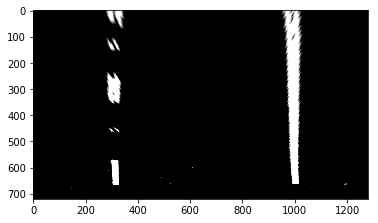

In [178]:
# apply perspective transformationm  to above binary image
def perspective_transform(gray):
    src = np.float32(
                    [
                        [447,550],
                        [300,650],
                        [874,550],
                        [1050,650]
                    ]
                    )
    dst = np.float32(
                    [
                        [300,550],
                        [300,650],
                        [1050,550],
                        [1050,650]
                    ]
                    )
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(gray, M, (gray.shape[1],gray.shape[0]), flags=cv2.INTER_LINEAR)
    return warped
wraped = perspective_transform(combined_binary)
plt.imshow(wraped,cmap='gray')

In [200]:
# detect lane pixels
def find_lane_pixels(wraped):
    converted_img = wraped/255
    bottom_half = converted_img[int(converted_img.shape[0]/2):,:]
    histogram = np.sum(bottom_half,axis=0)
    plt.plot(histogram)
    midpoint = np.int(histogram.shape[0]//2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    print(left_x_base)
    print(right_x_base)
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(converted_img.shape[0]//nwindows)
    nonzero = converted_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_x_current = leftx_base
    right_x_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = converted_img.shape[0]-(window+1)*window_height
        win_y_high = converted_img.shape[0]-window*window_height
        win_x_left_low = left_x_current-margin
        win_x_left_high = left_x_current+margin
        win_x_right_low = right_x_current-margin
        win_x_right_high = right_x_current+margin
        included_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_left_low) &  (nonzerox < win_x_left_high)).nonzero()[0]
        included_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_right_low) &  (nonzerox < win_x_right_high)).nonzero()[0]
        left_lane_inds.append(included_left_inds)
        right_lane_inds.append(included_right_inds)
        if len(included_left_inds) > minpix:
            left_x_current=np.int(np.mean(nonzerox[included_left_inds]))
        if len(included_right_inds) > minpix:
            right_x_current=np.int(np.mean(nonzerox[included_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx,lefty,rightx,righty


320
993
[302 303 304 ... 346 347 348]
[640 640 640 ...  71  71  71]


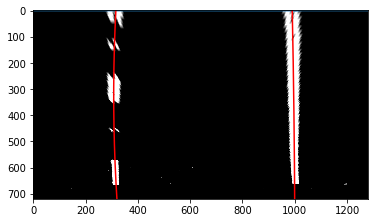

In [205]:
# fit the lane boundary
def fit_polynomial(binary_wraped):
    leftx, lefty, rightx, righty = find_lane_pixels(binary_wraped)
    print(leftx)
    print(lefty)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_wraped.shape[0]-1, binary_wraped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    return binary_wraped

out_img = fit_polynomial(wraped)
plt.imshow(wraped,cmap='gray')

In [9]:
# Determine the curvature of the lane and vehicle position with respect to center

In [10]:
# Warp the detected lane boundaries back onto the original image

In [ ]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature 
# and vehicle position